# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
import nltk
from nltk import pos_tag
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize  
from nltk.stem import WordNetLemmatizer 
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42

In [4]:
data = pd.read_csv(r'~/toxic_comments.csv')
data.head(15)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Столбец Unnamed: 0 повторяет нумерацию. Можем его удалить.

In [6]:
data = data.drop(['Unnamed: 0'], axis=1)

In [7]:
data.head(15)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


Проверим на пропуски и дубликаты

In [8]:
print('Количество пропусков:\n', data.isna().sum())

Количество пропусков:
 text     0
toxic    0
dtype: int64


In [9]:
print('Количество дубликатов:', data.duplicated().sum())

Количество дубликатов: 0


Данные хорошие, без пропусков и дублей. Был один лишний столбец.

Построим гистограмму для наглядности.

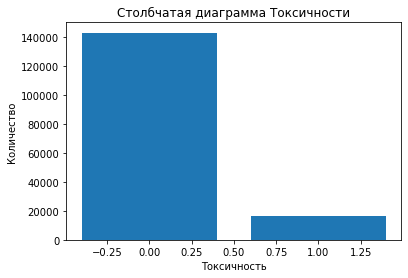

In [10]:
toxic_counts = data['toxic'].value_counts()
plt.bar(toxic_counts.index, toxic_counts.values) 

plt.xlabel('Токсичность')
plt.ylabel('Количество')
plt.title('Столбчатая диаграмма Токсичности')

plt.show()

Большинство отзывов положительные.

In [11]:
stop_words = set(stopwords.words('english'))

In [12]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Пользователь\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [16]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Пользователь\AppData\Roaming\nltk_data...


True

In [18]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Пользователь\AppData\Roaming\nltk_data...


True

In [19]:
wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

In [20]:
def preprocessing(text):
    
    text = re.sub(r'[^a-zA-Z ]', ' ', text) # удаление небуквенных символов
    tokens = [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
              for word, tag in pos_tag(word_tokenize(text))] # лемматизация
    text = ' '.join(tokens) # объединение токенов
    return text

In [21]:
data['lemm_text'] = data['text'].progress_apply(preprocessing)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [22]:
data.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


In [23]:
df = data.copy()

In [24]:
df = df.drop(['text'], axis = 1)

In [25]:
df.head()

,toxic,lemm_text
0,0,explanation why the edits make under my userna...
1,0,d aww he match this background colour i m seem...
2,0,hey man i m really not try to edit war it s ju...
3,0,more i can t make any real suggestion on impro...
4,0,you sir be my hero any chance you remember wha...


In [26]:
y = df['toxic']
X = df.drop(['toxic'], axis=1)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.1, stratify=y)

In [28]:
print('Train data shape:', X_train.shape, y_train.shape)
print('Test data shape:', X_test.shape, y_test.shape)

Train data shape: (143362, 2) (143362,)
Test data shape: (15930, 2) (15930,)


Данные подготовлены для обучения модели: они векторизированы, очищены от стоп-слов, лемматизированы. Также они разбиты на тренировачную выборку и тестовую.

## Обучение

In [29]:
def training(model, params):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(min_df = 1)),
        ('model', model)])
    grid = GridSearchCV(pipeline, param_grid = params, cv = 3, n_jobs = -1, scoring = 'f1', verbose = False)
    grid.fit(X_train['lemm_text'], y_train)
    print('Лучший результат:', grid.best_score_)
    print('Лучшие параметры:', grid.best_params_)
    return grid

In [30]:
lr_model = training(LogisticRegression(), {"model__C":[7, 10]})

Лучший результат: 0.7819193606995191
Лучшие параметры: {'model__C': 10}


In [31]:
rm_model = training(DecisionTreeClassifier(), {'model__max_depth':[4,10]})

Лучший результат: 0.5823109086493912
Лучшие параметры: {'model__max_depth': 10}


На тренировачной выборке себя лучше показала LogisticRegression

In [32]:
y_pred = lr_model.predict(X_test['lemm_text'])

In [33]:
print("Результат LogisticRegression", f1_score(y_test, y_pred))

Результат LogisticRegression 0.7796842827728209


Метрика f1 больше 0.75. Модель справилась.

## Выводы

В проекте нужно было обучить модель классифицировать комментарии на позитивные и негативные. Модель LogisticRegression справилась лучше, чем DecisionTreeClassifier. Метрика f1 на тренировачной выборке 0.78 у первой модели, у второй 0.583. На тестовой выборке метрика f1 модели LogisticRegression составила 0.785.